In [1]:
import keras
from keras.models import Model
from keras.layers import Input, Dense, Concatenate, Flatten, Reshape
from keras.layers import GlobalAveragePooling2D, Dropout, UpSampling2D, Conv2D, MaxPooling2D, Activation

import params

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

import tqdm
from tqdm import tqdm_notebook as tqdm

Using TensorFlow backend.


In [2]:
descriptor_size = 512

In [3]:
def BuildModel_AE():
    inp = Input(shape=(params.GetImageSize(), params.GetImageSize(), params.GetChannelsNum()))

    conv_1_1 = Conv2D(32, (3, 3), padding='same')(inp)
    conv_1_1 = Activation('relu')(conv_1_1)
    conv_1_2 = Conv2D(32, (3, 3), padding='same')(conv_1_1)
    conv_1_2 = Activation('relu')(conv_1_2)
    pool_1 = MaxPooling2D(2)(conv_1_2)

    conv_2_1 = Conv2D(64, (3, 3), padding='same')(pool_1)
    conv_2_1 = Activation('relu')(conv_2_1)
    conv_2_2 = Conv2D(64, (3, 3), padding='same')(conv_2_1)
    conv_2_2 = Activation('relu')(conv_2_2)
    pool_2 = MaxPooling2D(2)(conv_2_2)

    conv_3_1 = Conv2D(128, (3, 3), padding='same')(pool_2)
    conv_3_1 = Activation('relu')(conv_3_1)
    conv_3_2 = Conv2D(256, (3, 3), padding='same')(conv_3_1)
    conv_3_2 = Activation('relu')(conv_3_2)
    pool_3 = MaxPooling2D(2)(conv_3_2)
    
    flat_1 = Flatten()(pool_3)
    
    descriptor = Dense(descriptor_size, name='descriptor')(flat_1)
    
    req_h = int(params.GetImageSize() / 2 / 2 / 2)
    req_w = int(params.GetImageSize() / 2 / 2 / 2)
    descr_rescale = Dense(req_h * req_w)(descriptor)
    descr_resample = Reshape((32, 32, 1))(descr_rescale)

    up_1 = UpSampling2D(2, interpolation='bilinear')(descr_resample)
    conv_up_1_1 = Conv2D(256, (3, 3), padding='same')(up_1)
    conv_up_1_1 = Activation('relu')(conv_up_1_1)
    conv_up_1_2 = Conv2D(256, (3, 3), padding='same')(conv_up_1_1)
    conv_up_1_2 = Activation('relu')(conv_up_1_2)

    up_2 = UpSampling2D(2, interpolation='bilinear')(conv_up_1_2)
    conv_up_2_1 = Conv2D(128, (3, 3), padding='same')(up_2)
    conv_up_2_1 = Activation('relu')(conv_up_2_1)
    conv_up_2_2 = Conv2D(128, (3, 3), padding='same')(conv_up_2_1)
    conv_up_2_2 = Activation('relu')(conv_up_2_2)

    up_3 = UpSampling2D(2, interpolation='bilinear')(conv_up_2_2)
    conv_up_3_1 = Conv2D(64, (3, 3), padding='same')(up_3)
    conv_up_3_1 = Activation('relu')(conv_up_3_1)
    conv_up_3_2 = Conv2D(3, (3, 3), padding='same')(conv_up_3_1)
    result = Activation('sigmoid')(conv_up_3_2)
    
    return Model(inputs=inp, outputs=result)

best_w = keras.callbacks.ModelCheckpoint('best.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=True,
                                save_weights_only=False,
                                mode='auto',
                                period=1)

last_w = keras.callbacks.ModelCheckpoint('last.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=False,
                                save_weights_only=False,
                                mode='auto',
                                period=1)


callbacks = [best_w, last_w]


model = BuildModel_AE()
adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(adam, 'mse')

In [4]:
import cv2
import numpy as np
import os, shutil
import glob
import random

def GenerateImage(image, sample_width, sample_height, use_scaling):
    height, width, _ = image.shape
    
    scale = random.uniform(0.9, 2) if use_scaling else 1
    
    scaled_sample_width = int(round(sample_width))
    scaled_sample_height = int(round(sample_height))
    
    x_offset = random.randint(0, width - scaled_sample_width - 1)
    y_offset = random.randint(0, height - scaled_sample_height - 1)

    sample = image[y_offset:y_offset + scaled_sample_height, x_offset:x_offset + scaled_sample_width]
    sample = cv2.resize(sample, (sample_width, sample_height))
    
    angles = [0, 90, 180, 270]
    angle = random.choice(angles)
    if angle > 0:
        for i in range(int(angle / 90)):
            sample = np.rot90(sample)
    
    return sample

def keras_generator(basepath, batch_size, use_scaling=True, class_template=''):
    origin_img_files = glob.glob(os.path.join(basepath, class_template + '*.*'))
    
    origin_imgs = [ cv2.imread(img_name, cv2.IMREAD_COLOR) for img_name in origin_img_files ]
    
    index = 0
    while True:
        x_batch = []
        y_batch = []
        
        for i in range(batch_size):
            index = random.randint(0, len(origin_imgs) - 1)
            
            img = GenerateImage(origin_imgs[index], params.GetImageSize(), params.GetImageSize(), use_scaling)
            
            x_batch += [img]
            y_batch += [img]
            

        yield np.array(x_batch), np.array(y_batch)

In [5]:
batch_size = 8

In [6]:
history = model.fit_generator(keras_generator('./imgs', batch_size),
              steps_per_epoch=15,
              epochs=3,
              verbose=1,
              callbacks=callbacks,
              validation_data=keras_generator('./imgs', batch_size),
              validation_steps=3,
              class_weight=None,
              max_queue_size=10,
              workers=1,
              use_multiprocessing=False,
              shuffle=True,
              initial_epoch=0)

Epoch 1/3
15/15 [==============================] - 250s 17s/step - loss: 17378.8139 - val_loss: 15092.8281
Epoch 2/3
15/15 [==============================] - 254s 17s/step - loss: 17534.1104 - val_loss: 19672.7161
Epoch 3/3
15/15 [==============================] - 250s 17s/step - loss: 17498.2514 - val_loss: 22101.4421


['loss', 'val_loss']


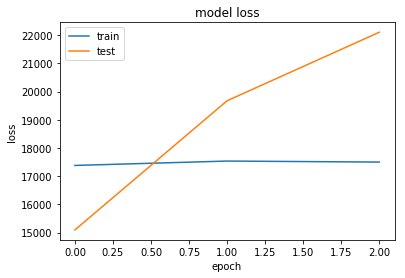

In [7]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [6]:
from keras.models import load_model
model1 = load_model('best.h5')

In [7]:
intermediate_layer_model = Model(inputs=model1.input, outputs=model1.get_layer('descriptor').output)

In [8]:
testing_batch_size = 16

for x, y in keras_generator('./imgs_test', testing_batch_size, False):
    break
intermediate_output = intermediate_layer_model.predict(x)
print(x.shape, intermediate_output.shape)

((16, 256, 256, 3), (16, 512))


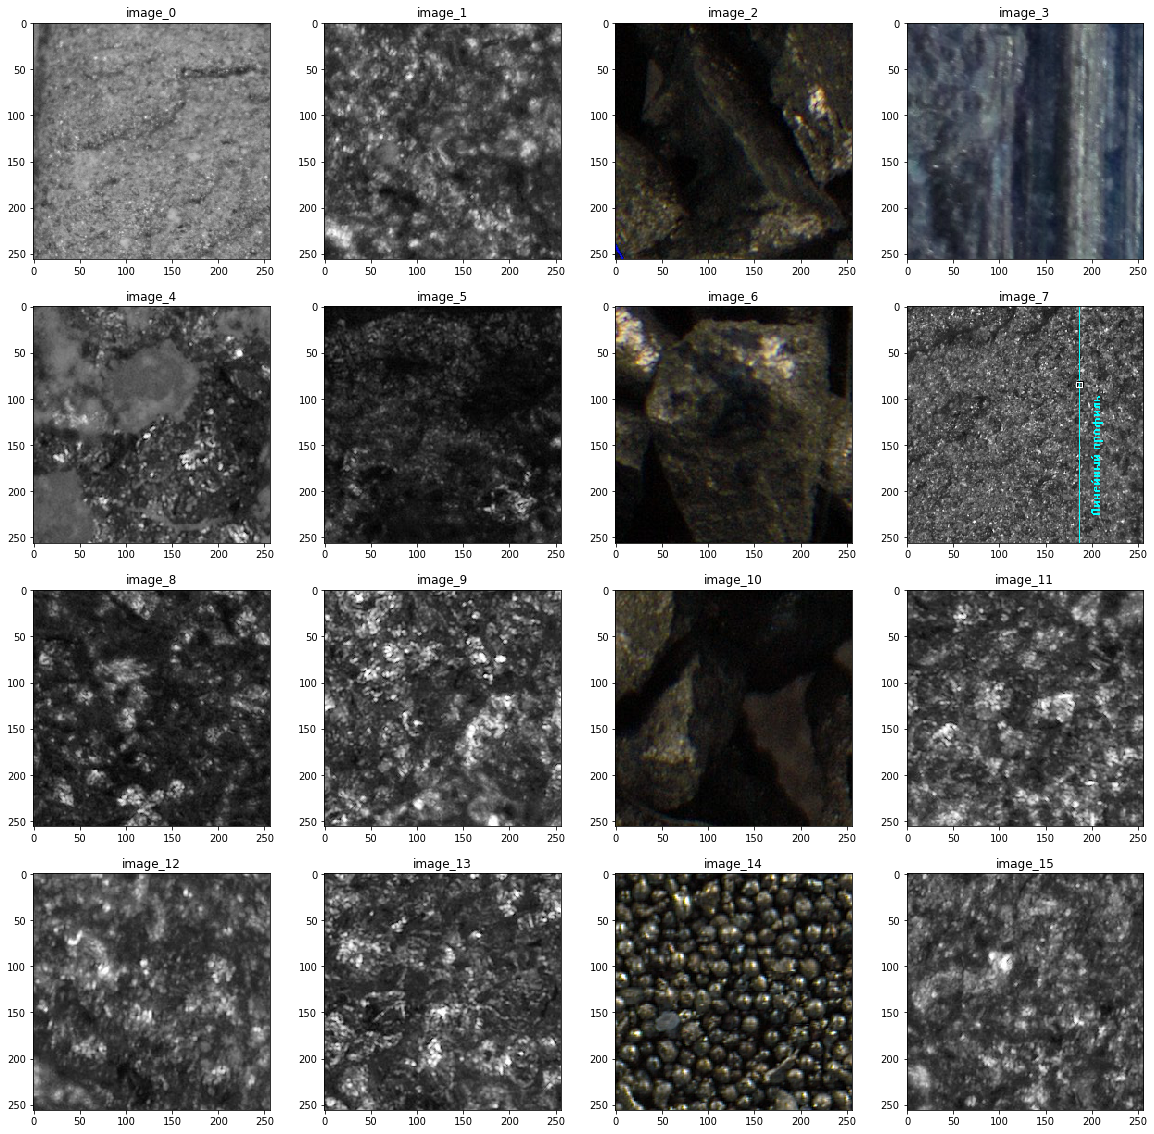

In [9]:
import matplotlib.pyplot as plt

data_count = x.shape[0]

fig, axes = plt.subplots(nrows=int(data_count/4), ncols=4, figsize=(20, 20))
for i in range(data_count):
    row = int(i / 4)
    col = int(i % 4)
    axes[row][col].imshow(x[i, :, :, :])
    axes[row][col].set_title('image_' + str(i))
    #axes[i][1].plot(intermediate_output[i,:])


# axes[0][0].imshow(x[0, :, :, :])
# axes[1][0].imshow(x[1, :, :, :])
# axes[2][0].imshow(x[2, :, :, :])
# axes[3][0].imshow(x[3, :, :, :])

# #plt.plot(t, t, 'r--', t, t**2, 'bs', t, t**3, 'g^')
# axes[0][1].plot(intermediate_output[0,:], 'r')
# axes[1][1].plot(intermediate_output[1,:], 'b')
# axes[2][1].plot(intermediate_output[2,:], 'g')
# axes[3][1].plot(intermediate_output[3,:], 'k')

plt.show()

In [10]:
in_data = intermediate_output.transpose()
mean, eigenvectors = cv2.PCACompute(in_data, np.mean(in_data, axis=0).reshape(1,-1), maxComponents=2)

In [11]:
mean, eigenvectors

(array([[17.907043 , 13.274299 ,  5.385392 , 11.108891 , 12.284994 ,
          6.0897045,  6.2912464, 15.664098 ,  9.320933 , 14.923218 ,
          4.0942636, 14.251677 , 12.916922 , 13.559565 , 12.214536 ,
         13.541933 ]], dtype=float32),
 array([[ 0.37707108,  0.27464706,  0.11270807,  0.22934227,  0.25334042,
          0.12308147,  0.13691567,  0.3252439 ,  0.19298442,  0.30393592,
          0.08327641,  0.29589579,  0.2675269 ,  0.2826263 ,  0.2442145 ,
          0.27933362],
        [-0.23328888,  0.1778596 , -0.5976572 , -0.2107416 ,  0.2241844 ,
          0.09030651,  0.0616781 , -0.2711131 ,  0.19218251,  0.27165708,
          0.29608965, -0.33331305,  0.20262314,  0.06610779,  0.13803235,
          0.05136317]], dtype=float32))

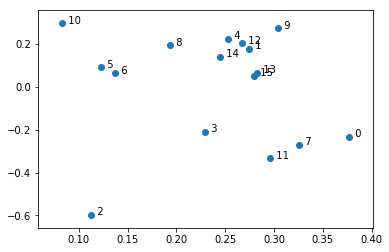

In [12]:
eigenvectors[:,0]
view_data = eigenvectors

fig, ax = plt.subplots()
ax.scatter(view_data[0,:], view_data[1,:])

for i in range(len(view_data[0,:])):
    ax.annotate('  ' + str(i), (view_data[0,:][i], view_data[1,:][i]))

plt.show()

In [13]:
testing_batch_size = 16

classes_num = 8
classified_data = np.zeros((testing_batch_size * classes_num, descriptor_size)).astype(np.float32)

samples = []

for class_idx in range(classes_num):
    for x, _ in keras_generator('./imgs_classified', testing_batch_size, False, str(class_idx)):
        break
    sp = testing_batch_size * class_idx
    tp = testing_batch_size * (class_idx + 1)
    classified_data[sp:tp] = intermediate_layer_model.predict(x)
    samples.append(x[:, :, :, :])


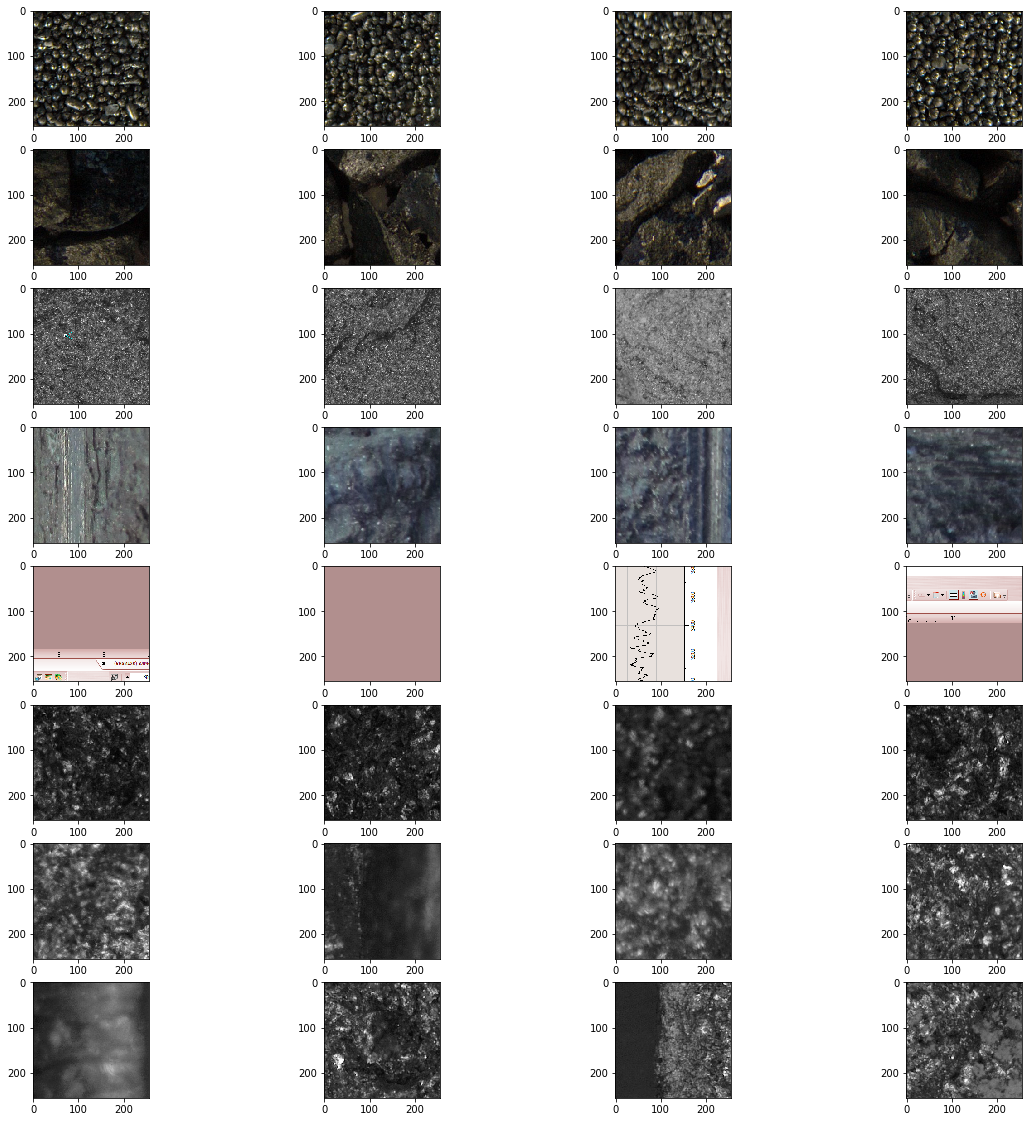

In [14]:
data_count = classified_data.shape[0]

fig, axes = plt.subplots(nrows=int(classes_num), ncols=4, figsize=(20, 20))
for row in range(classes_num):
    for col in range(4):
        axes[row][col].imshow(samples[row][col, :, :, :])
    
plt.show()

In [15]:
in_data = classified_data.transpose()
mean, eigenvectors = cv2.PCACompute(in_data, np.mean(in_data, axis=0).reshape(1,-1), maxComponents=2)


In [16]:
eigenvectors.shape

(2, 128)

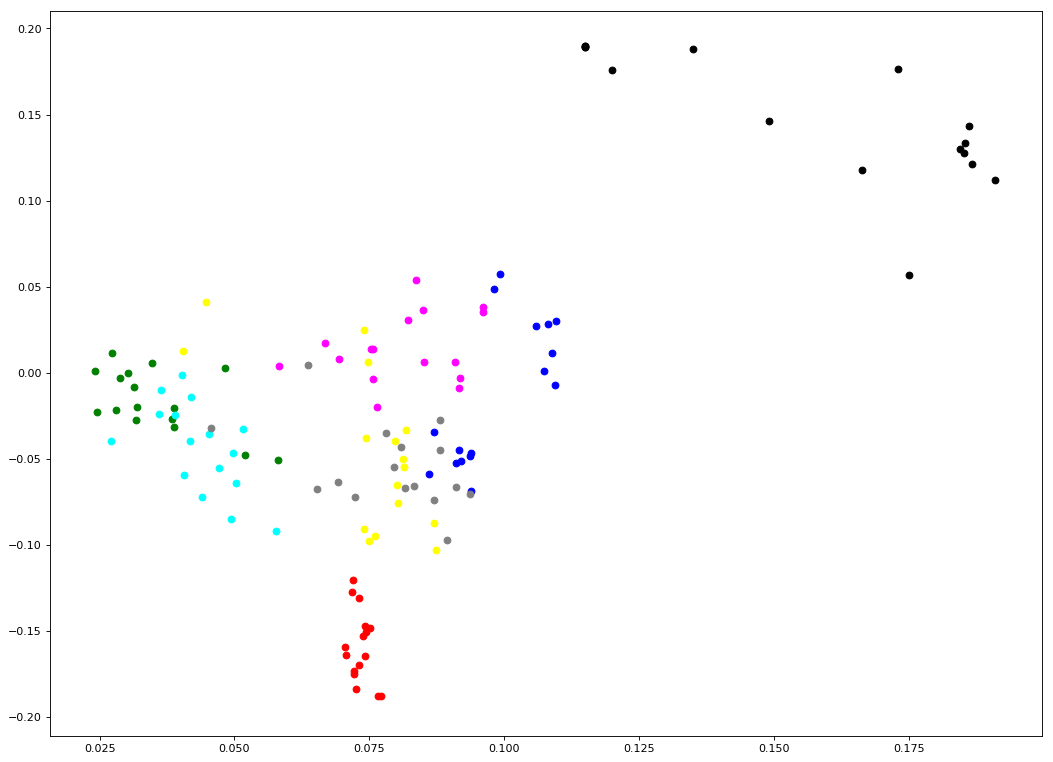

In [17]:
view_data = eigenvectors

fig, ax = plt.subplots(figsize=(16, 12), dpi=80)

colors = ['red', 'green', 'blue', 'magenta', 'black', 'cyan', 'yellow', 'gray', 'brown', 'orange']
for class_idx in range(classes_num):
    sp = testing_batch_size * class_idx
    tp = testing_batch_size * (class_idx + 1)
    ax.scatter(view_data[0,sp:tp], view_data[1,sp:tp], c=colors[class_idx])

plt.show()

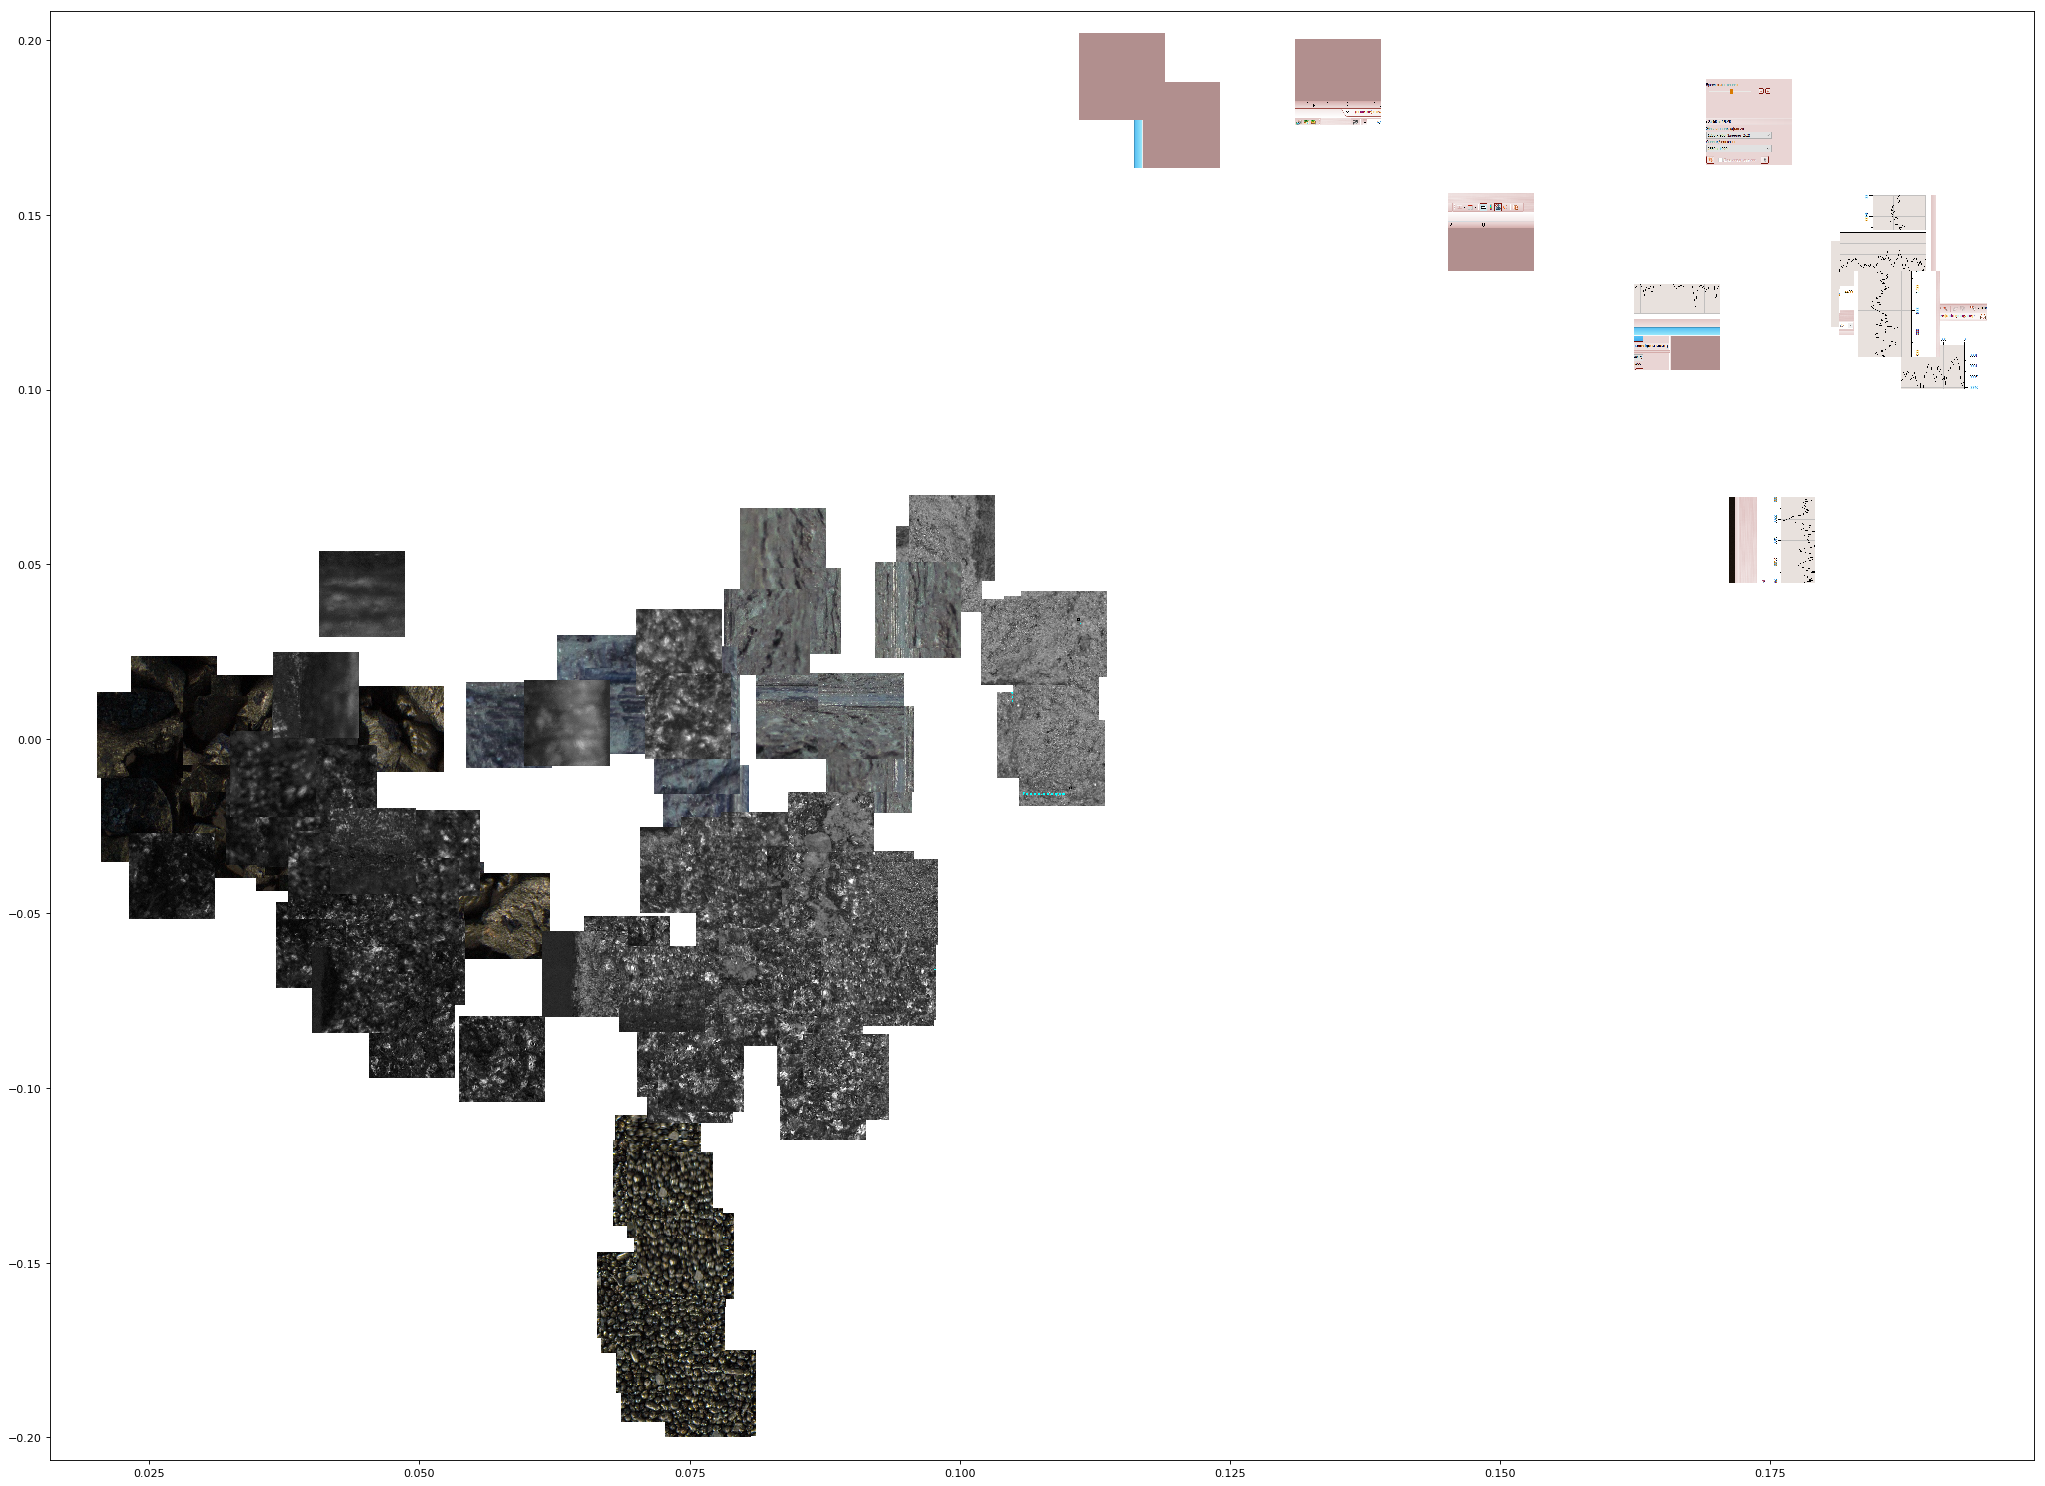

In [18]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

view_data = eigenvectors

fig, ax = plt.subplots(figsize=(32, 24), dpi=80)

# colors = ['red', 'green', 'blue', 'magenta', 'black']
# for class_idx in range(classes_num):
#     sp = testing_batch_size * class_idx
#     tp = testing_batch_size * (class_idx + 1)
#     ax.scatter(view_data[0,sp:tp], view_data[1,sp:tp], c=colors[class_idx])
    
zoom = 0.3
for row in range(classes_num):
    for col in range(testing_batch_size):
        im = OffsetImage(samples[row][col, :, :, :], zoom=zoom)
        sp = testing_batch_size * row + col
        ab = AnnotationBbox(im, (view_data[0,sp], view_data[1,sp]), xycoords='data', frameon=False)
        ax.add_artist(ab)
ax.update_datalim(np.column_stack([view_data[0,:], view_data[1,:]]))
ax.autoscale()

plt.show()